In [1]:
from bs4 import BeautifulSoup as bs
import itertools
from itertools import combinations
import re
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

### Делаем функцию для открытия размеченного дневника формата xml

In [2]:
def open_xml(path):
    f = open(path)
    diary = f.read()
    f.close()
    soup = bs(diary, 'xml')
    return soup

### Создаем функцию, которая находит упоминания людей под нужным нам тэгом ('p' - просто в абзаце, 'meeting' - именно встречу, а не упоминание в рассказе или письмо). Получается список списков.

In [4]:
def mentions_of_people(soup, tag):
    all_mentions = []
    for par in soup.find_all(tag):
        mentioned_ref = list(set([persName.get('ref') for persName in par.find_all('persName')]))
        if len(mentioned_ref) != 0:
            all_mentions.append(mentioned_ref)
    return all_mentions

### Создаем mentions_table - таблицу-матрицу, в которой будут обозначены встречи/пересечения/упоминания людей в одном параграфе или в одной встрече

In [5]:
'''Эта функция нужна для того, чтобы выудить из всех наших упоминаний уникальные фамилии
в соответствии с ними сделать нужного размера матрицу'''
def lst_surnames_of_further_matrix(all_mentions):
    surnames_for_further_matrix = []
    for mention in all_mentions:
        surnames_for_further_matrix += mention
    unique_surnames_for_further_matrix = list(sorted(set(surnames_for_further_matrix)))
    return unique_surnames_for_further_matrix

In [6]:
def make_mentions_table(unique_surnames_for_further_matrix, all_mentions):
    
    '''эта функция создает нужного размера матрицу'''
    
    num_surnames = len(unique_surnames_for_further_matrix)
    mentions_table = pd.DataFrame(data=np.zeros(shape=(num_surnames, num_surnames)), 
                                  columns=unique_surnames_for_further_matrix,
                                  index=unique_surnames_for_further_matrix)
    
    def add_person_2_table(mentions_table, surname_list):
        
        '''эту функцию прибавления встреч в матрицу я засунула в функцию по созданию таблицы, чтобы при
        обновлении кода таблица обновлялась. Иначе она получается кумулятивной. Surname_list - фиктивная
        переменная из следующей команды в этом чанке'''
        
        for surname_1 in surname_list:
            for surname_2 in surname_list:
                mentions_table.at[surname_1, surname_2] += 1 
                #dataframe.at - фишка pandas, благодаря чему на пересечении двух фамилий прибавляется единица
        return mentions_table

    for surname_list in all_mentions:
        add_person_2_table(mentions_table, surname_list)
    
    return mentions_table

# pd.set_option('display.max_rows', 308)
# pd.set_option('display.max_columns', 308)

### Можем превратить нашу матрицу в таблицу с тремя колонками - кто, с кем и сколько раз пересекался

In [7]:
def table_2_3column(table, to_dataframe=True):
    new_table = []
    names = table.columns
    for i in range(len(table)):
        for j in range(i, len(table)):
            if table.iloc[i, j] != 0:
                new_table.append([names[i], names[j], table.iloc[i, j]])
    if to_dataframe:
        return pd.DataFrame(new_table, columns=('Source', 'Target', 'Weight'))
    return new_table

### Финальная функция, в которой создается и сохраняется таблица для каждого года 

In [8]:
def creating_a_table_for_each_year():
    for x in range(1928, 1940):
        soup = open_xml('Processed_Diary-{}.xml'.format(x))
        all_mentions = mentions_of_people(soup, 'meeting')
        
        all_mentions_with_Bunins = mentions_of_people(soup, 'meeting')
        for list_with_names in all_mentions_with_Bunins:
            list_with_names.append('#bunins')
            
        '''тут можно выбрать другой тэг, например <note>'''
        unique_surnames_for_further_matrix = lst_surnames_of_further_matrix(all_mentions)
        unique_surnames_for_further_matrix_with_Bunins = lst_surnames_of_further_matrix(all_mentions_with_Bunins)
        
        mentions_table = make_mentions_table(unique_surnames_for_further_matrix, all_mentions)
        mentions_table_with_Bunins = make_mentions_table(unique_surnames_for_further_matrix_with_Bunins, all_mentions_with_Bunins)
        
        final_table = table_2_3column(mentions_table)
        final_table_with_Bunins = table_2_3column(mentions_table_with_Bunins)
        
        final_table.to_csv('Table_{}.csv'.format(x), index = False, sep='\t')
        final_table_with_Bunins.to_csv('Table_with_Bunins_{}.csv'.format(x), index = False, sep='\t')
 

In [13]:
def creating_a_table_for_all_years(path):
    soup = open_xml(path)
    
    all_mentions = mentions_of_people(soup, 'meeting')
    all_mentions_with_Bunins = mentions_of_people(soup, 'meeting')
    for list_with_names in all_mentions_with_Bunins:
            list_with_names.append('#bunins')
            
    '''тут можно выбрать другой тэг, например <note>'''
    unique_surnames_for_further_matrix = lst_surnames_of_further_matrix(all_mentions)
    unique_surnames_for_further_matrix_with_Bunins = lst_surnames_of_further_matrix(all_mentions_with_Bunins)

    mentions_table = make_mentions_table(unique_surnames_for_further_matrix, all_mentions)
    mentions_table_with_Bunins = make_mentions_table(unique_surnames_for_further_matrix_with_Bunins, all_mentions_with_Bunins)

    final_table = table_2_3column(mentions_table)
    final_table_with_Bunins = table_2_3column(mentions_table_with_Bunins)
    
    

    final_table.to_csv('Table_for_all_years.csv', index = False, sep='\t')
    final_table_with_Bunins.to_csv('Table_with_Bunins_for_all_years.csv', index = False, sep='\t')

In [10]:
creating_a_table_for_each_year()

In [14]:
creating_a_table_for_all_years('Processed_Marked_text.xml')

### Для будущей таблицы атрибутов сделаем список референсов

In [12]:
'''здесь надо открыть файл со всеми дневниками'''
persNames = soup.find_all('persName')
lst_of_refs = []
for name in persNames:
    lst_of_refs.append(name.get('ref'))

NameError: name 'soup' is not defined

In [ ]:
lst_of_unique_refs = sorted(list(set(lst_of_refs)))

In [ ]:
len(lst_of_unique_refs)

In [ ]:
with open('List_of_refs.txt', 'w') as file:
    for line in lst_of_unique_refs:
        file.write(line+'\n')

In [3]:
quantity_of_notes = []
for x in range(1928, 1940):
    soup = open_xml('Processed_Diary-{}.xml'.format(x))
    all_notes = soup.find_all ('note')
    quantity_of_notes.append(len(all_notes))

In [4]:
quantity_of_notes

[64, 85, 75, 51, 53, 51, 21, 12, 19, 15, 3, 40]

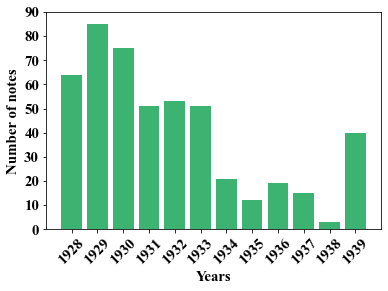

In [5]:
dic_quantity_of_notes = {i + 1928: quantity_of_notes[i] for i, quantity_of_notes[i] \
                          in enumerate(quantity_of_notes)}

font_args = {'fontname':'Times New Roman', 'size': '15'}

plt.bar(dic_quantity_of_notes.keys(), dic_quantity_of_notes.values(), color='mediumseagreen')
plt.xticks(range(1928, 1940),rotation=45, **font_args)
plt.yticks(range(0, 100, 10), **font_args)
plt.xlabel('Years', **font_args)
plt.ylabel('Number of notes', **font_args)
plt.savefig('Num_of_notes.png',bbox_inches="tight")